# Quando eu voo

A base de dados quando eu voo é resultado de uma raspagem de preços de passagens aéreas no website da GOL e LATAM, utilizando a biblioteca selenium em Python foi possível coletar dados de passagens partindo de São Paulo para diversos destinos no dia 01/12.
https://medium.com/@lamartine_sl/regressão-linear-com-sklearn-modelo-de-previsão-de-custos-com-plano-de-saúde-5e963e590f4c
https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
import pandas as pd

In [26]:
#Conexão com Mysql
conn = mysql.connector.connect(user='root', password='root', host='127.0.0.1', database='quando_eu_voo')
cursor = conn.cursor()
cursor.execute("""select passagem.dataPesquisa, voo.destino, voo.destinoSigla, passagem.companhia, passagem.media
                    from passagem
                    INNER JOIN voo ON passagem.idVoo = voo.idVoo
                    order by passagem.dataPesquisa;""")

medias = cursor.fetchall()

cursor.execute("""select passagem.dataPesquisa, voo.destino, voo.destinoSigla, passagem.companhia, tp_passagem.hSaida, tp_passagem.duracao, tp_passagem.preco
                    from passagem
                    INNER JOIN voo ON passagem.idVoo = voo.idVoo
                    inner join tp_passagem on passagem.idPassagem = tp_passagem.idPassagem
                    where tp_passagem.tipoPassagem = 'MAIOR'
                    order by passagem.dataPesquisa;""")

maiores = cursor.fetchall()

cursor.execute("""select passagem.dataPesquisa, voo.destino, voo.destinoSigla, passagem.companhia, tp_passagem.hSaida, tp_passagem.duracao, tp_passagem.preco
                    from passagem
                    INNER JOIN voo ON passagem.idVoo = voo.idVoo
                    inner join tp_passagem on passagem.idPassagem = tp_passagem.idPassagem
                    where tp_passagem.tipoPassagem = 'MENOR'
                    order by passagem.dataPesquisa;""")


menores = cursor.fetchall()
print("Connection established")
conn.close()

#Pandas dataFrame
df_medias = pd.DataFrame(medias, columns=['data da pesquisa', 'destino', 'sigla', 'companhia','valor'])
df_maiores = pd.DataFrame(maiores, columns=['data da pesquisa', 'destino', 'sigla', 'companhia', 'saida', 'duração', 'valor'])
df_menores = pd.DataFrame(menores, columns=['data da pesquisa', 'destino', 'sigla', 'companhia', 'saida', 'duração', 'valor'])

df_menores.head()

Connection established


,data da pesquisa,destino,sigla,companhia,saida,duração,valor
0,2022-10-19,"Rio Branco, RBR - Brasil",RBR,GOL,22:40,04:15,982.16
1,2022-10-19,"Maceió, MCZ - Brasil",MCZ,GOL,21:45,02:55,886.16
2,2022-10-19,"Manaus, MAO - Brasil",MAO,GOL,22:05,03:50,1144.16
3,2022-10-19,"Salvador da Bahia, SSA - Brasil",SSA,GOL,21:35,02:20,970.16
4,2022-10-19,"Fortaleza, FOR - Brasil",FOR,GOL,21:20,03:25,670.17


# Modelos Preditivos:

## Regressão Linear Múltipla

(Preços menores).

- Preço (quantitativa)
- dias antes do voo (quantitativa)
- duração em minutos (quantitativa)

In [65]:
df_menores[(df_menores.sigla == "AJU") & (df_menores.companhia == "GOL")].head()

,data da pesquisa,destino,sigla,companhia,saida,duração,valor
21,2022-10-19,"Aracaju, AJU - Brasil",AJU,GOL,09:10,02:40,679.16
44,2022-10-19,"Aracaju, AJU - Brasil",AJU,GOL,23:25,02:45,679.16
67,2022-10-20,"Aracaju, AJU - Brasil",AJU,GOL,14:55,02:40,814.16
90,2022-10-20,"Aracaju, AJU - Brasil",AJU,GOL,23:25,02:45,679.16
113,2022-10-21,"Aracaju, AJU - Brasil",AJU,GOL,09:10,02:40,814.16


In [69]:
df_linmul = df_menores[(df_menores.sigla == "AJU") & (df_menores.companhia == "GOL")]

# Adicionando um dummy
df_linmul['Time'] = np.arange(len(df_linmul.index))
df_linmul['valor'] = df_linmul['valor'].astype('float')
df_linmul['duração'] = pd.to_datetime(df_linmul['duração'], errors='coerce')
df_linmul['duração'] = df_linmul['duração'].dt.minute + (df_linmul['duração'].dt.hour * 60)

df_linmul.head()

C:\Users\J.ABREU\AppData\Local\Temp\ipykernel_20216\1247071278.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linmul['Time'] = np.arange(len(df_linmul.index))
C:\Users\J.ABREU\AppData\Local\Temp\ipykernel_20216\1247071278.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linmul['valor'] = df_linmul['valor'].astype('float')
C:\Users\J.ABREU\AppData\Local\Temp\ipykernel_20216\1247071278.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,data da pesquisa,destino,sigla,companhia,saida,duração,valor,Time
21,2022-10-19,"Aracaju, AJU - Brasil",AJU,GOL,09:10,160,679.16,0
44,2022-10-19,"Aracaju, AJU - Brasil",AJU,GOL,23:25,165,679.16,1
67,2022-10-20,"Aracaju, AJU - Brasil",AJU,GOL,14:55,160,814.16,2
90,2022-10-20,"Aracaju, AJU - Brasil",AJU,GOL,23:25,165,679.16,3
113,2022-10-21,"Aracaju, AJU - Brasil",AJU,GOL,09:10,160,814.16,4


In [77]:
""" import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 12
 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

X1 = df_linmul.loc[:, ['Time']]  # features
X2 = df_linmul.loc[:, ['duração']]  # features
y = df_linmul.loc[:, ['valor']]  # target
 
ax.scatter(X1, X2, y, label ='y', s = 5)
ax.legend()
ax.view_init(45, 0)
 
plt.show() """

" import numpy as np\nimport matplotlib as mpl\nfrom mpl_toolkits.mplot3d import Axes3D\nimport matplotlib.pyplot as plt\n\nmpl.rcParams['legend.fontsize'] = 12\n \nfig = plt.figure()\nax = fig.add_subplot(projection='3d')\n\nX1 = df_linmul.loc[:, ['Time']]  # features\nX2 = df_linmul.loc[:, ['duração']]  # features\ny = df_linmul.loc[:, ['valor']]  # target\n \nax.scatter(X1, X2, y, label ='y', s = 5)\nax.legend()\nax.view_init(45, 0)\n \nplt.show() "

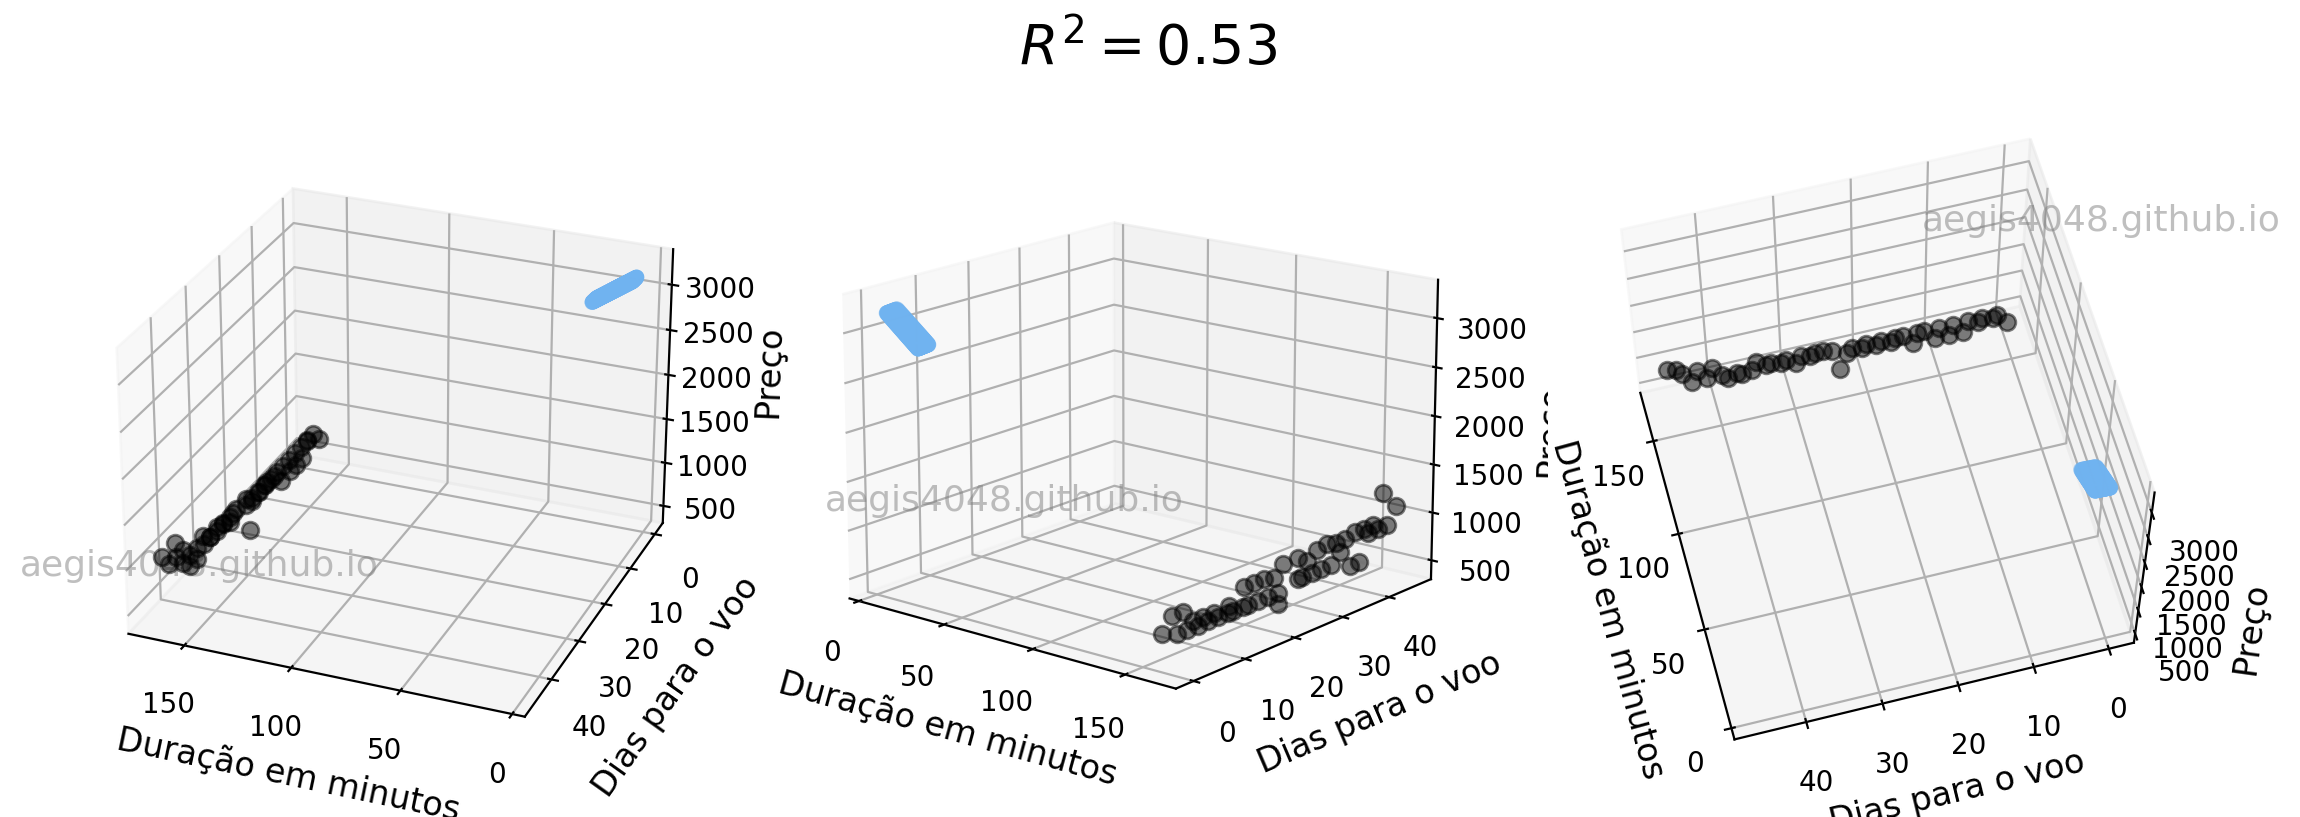

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D

X = df_linmul[['duração', 'Time']].values.reshape(-1,2)
Y = df_linmul['valor']

######################## Prepare model data point for visualization ###############################

x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(6, 24, 30)      # range of porosity values
y_pred = np.linspace(0.93, 2.9, 30)  # range of VR values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

################################################ Train #############################################

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)

############################################## Evaluate ############################################

r2 = model.score(X, Y)

############################################## Plot ################################################

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Duração em minutos', fontsize=12)
    ax.set_ylabel('Dias para o voo', fontsize=12)
    ax.set_zlabel('Preço ', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=27, azim=112)
ax2.view_init(elev=16, azim=-51)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()


## Regressão Polinomial

Foi utilizado o exemplo de gru - aju no dia 01/12 pela gol.
 
 - Preço 
 - Data de Pesquisa

In [14]:
df_poli = df_medias[(df_medias.sigla == "AJU") & (df_medias.companhia == "GOL")]
# Adicionando um dummy
df_poli['Time'] = np.arange(len(df_poli.index))
df_poli['valor'] = df_poli['valor'].astype('float')

C:\Users\J.ABREU\AppData\Local\Temp\ipykernel_20216\443314813.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_poli['Time'] = np.arange(len(df_poli.index))
C:\Users\J.ABREU\AppData\Local\Temp\ipykernel_20216\443314813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_poli['valor'] = df_poli['valor'].astype('float')


In [15]:
df_poli.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 42 to 1017
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   data da pesquisa  22 non-null     object 
 1   destino           22 non-null     object 
 2   sigla             22 non-null     object 
 3   companhia         22 non-null     object 
 4   valor             22 non-null     float64
 5   Time              22 non-null     int32  
dtypes: float64(1), int32(1), object(4)
memory usage: 1.1+ KB


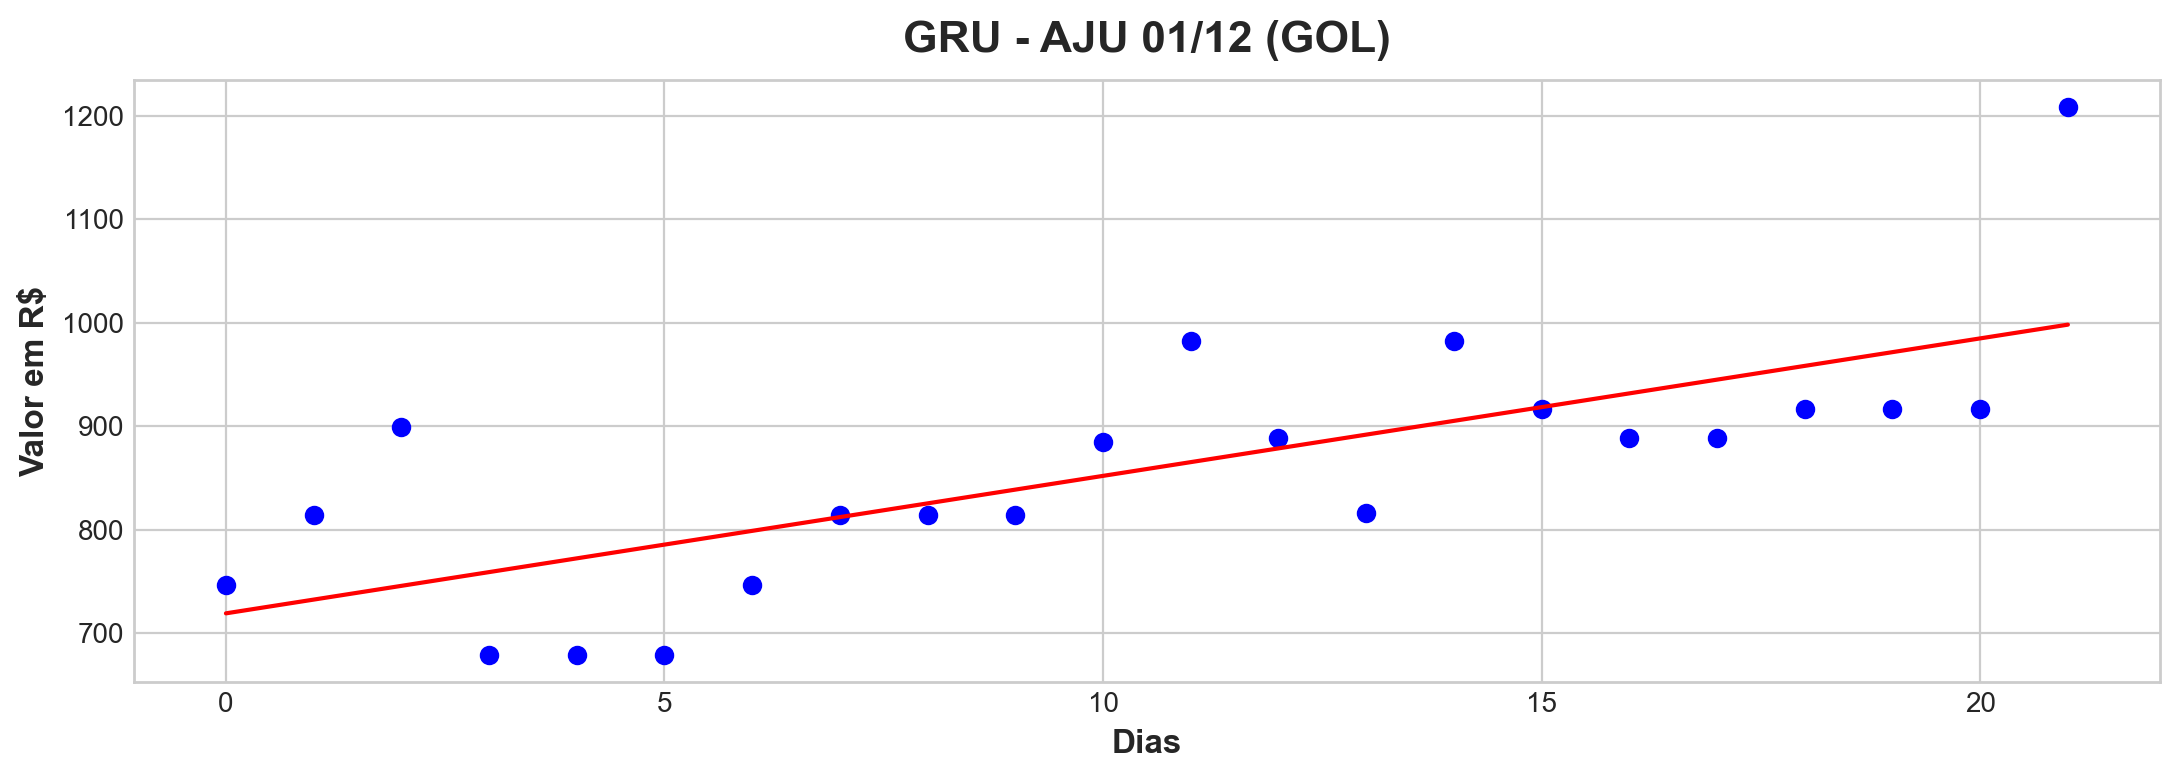

In [25]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

X = df_poli.loc[:, ['Time']]  # features
y = df_poli.loc[:, ['valor']]  # target

# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
  
lin.fit(X, y)


# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
  
poly = PolynomialFeatures(degree = 4)
X_poly = poly.fit_transform(X)
  
poly.fit(X_poly, y)
lin2 = LinearRegression()
lin2.fit(X_poly, y)

# Visualising the Linear Regression results
plt.scatter(X, y, color = 'blue')
  
plt.plot(X, lin.predict(X), color = 'red')
plt.title('GRU - AJU 01/12 (GOL)')
plt.ylabel('Valor em R$')
plt.xlabel('Dias')
  
plt.show()

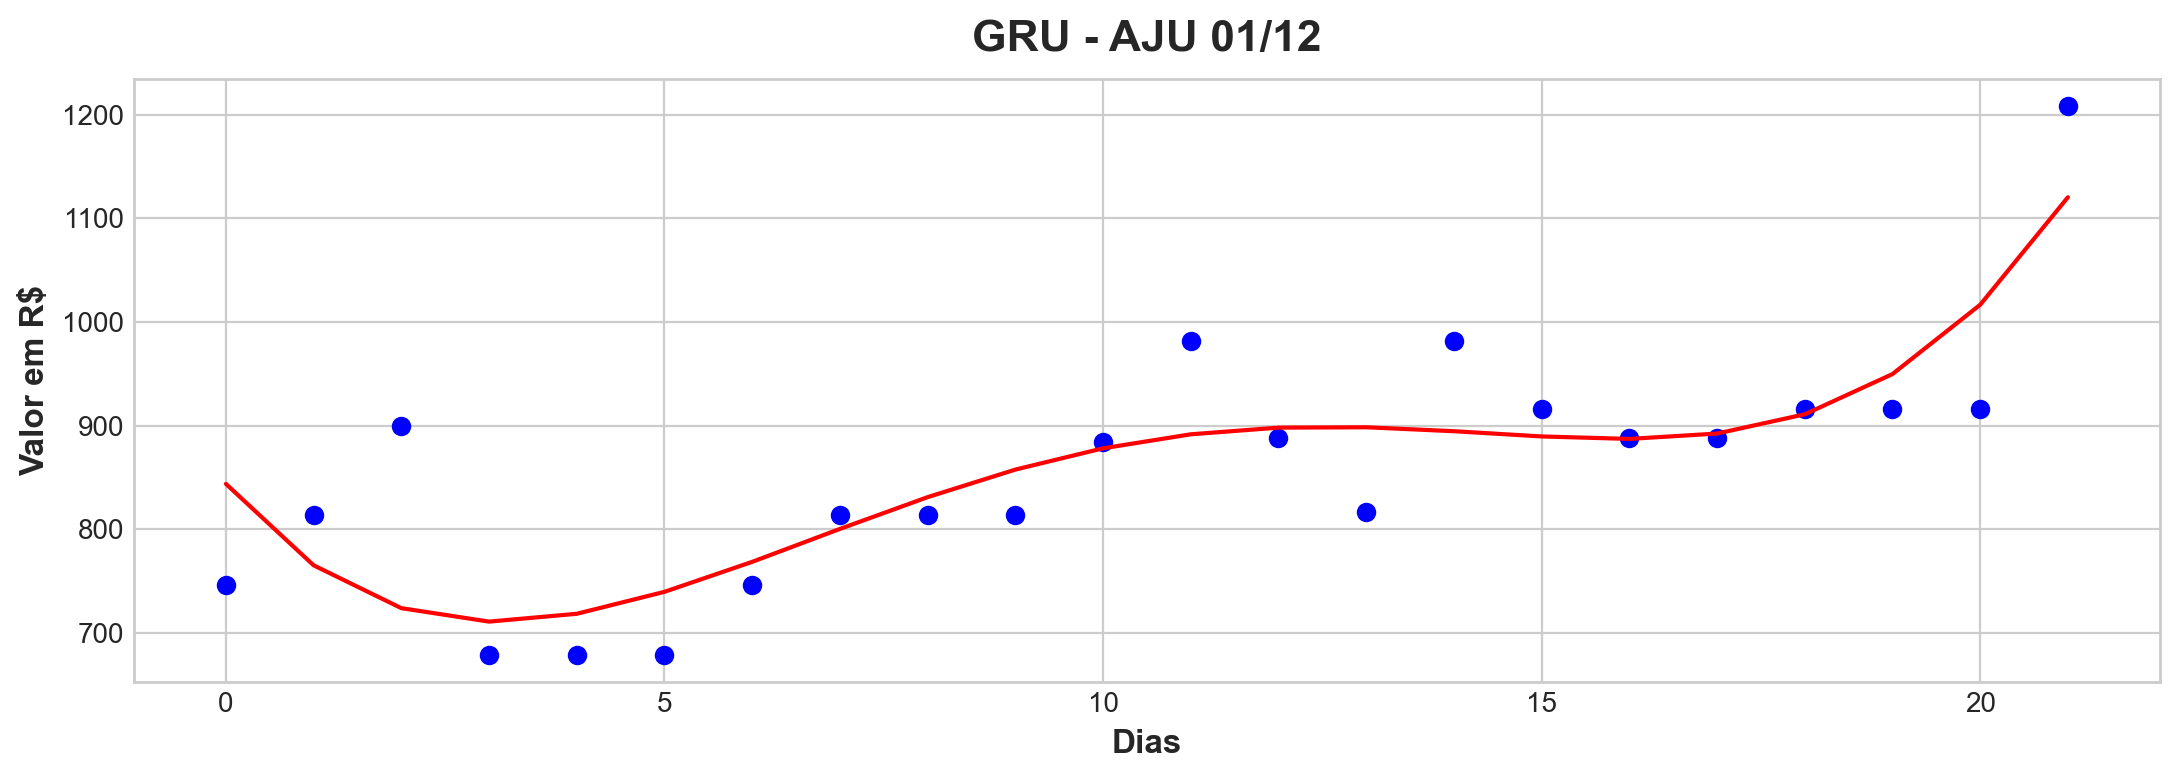

In [23]:

plt.scatter(X, y, color = 'blue')

# Polinomial  
plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'red')
plt.title('GRU - AJU 01/12 (GOL)')
plt.ylabel('Valor em R$')
plt.xlabel('Dias')
  
plt.show()